This notebook does 2 things:

1. Applies different resenet architectures and selects the
   model and architecture based on the validation loss.

1. Calculates AUC ROC score fo the best model.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from fastai2.metrics import RocAuc
from fastai2.vision.all import *

from sklearn.model_selection import train_test_split
import numpy as np

In [35]:
splitter = TrainTestSplitter(test_size=0.3,
                                               random_state=42)

In [36]:
x = splitter(train_df)

fastcore.foundation.L

In [2]:
train_df = pd.read_csv('data/train.csv')


dblock = DataBlock((ImageBlock, CategoryBlock),
                   splitter = TrainTestSplitter(test_size=0.3,
                                               random_state=42),
                   get_x = lambda r: f"data/jpeg/train-224/{r['image_name']}.jpg",
                   get_y = lambda r : str(r["target"]),
                   item_tfms = None)


dls = dblock.dataloaders(train_df,bs=32, num_workers = 0,)


In [3]:
x,y = dls.one_batch()

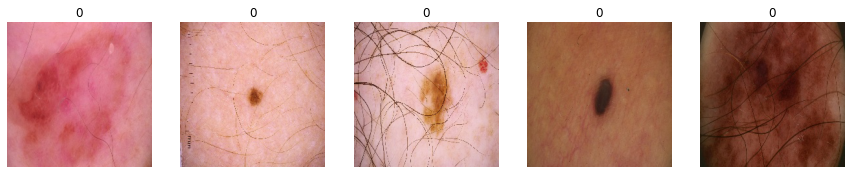

In [4]:
dls.show_batch(nrows=1, ncols=5)

In [6]:
class FocalLoss(BCEWithLogitsLossFlat):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [14]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=BCEWithLogitsLossFlat())

In [21]:
dls_large = dblock.dataloaders(train_df,bs=256, num_workers = 0)

In [22]:
learn.dls = dls_large

In [ ]:
learn.save('resnet18-v1')

In [34]:
print('complete')

complete


In [9]:
learn = cnn_learner(dls, resnet18,)

In [10]:
learn.load('resnet18-v1')

In [11]:
learn.metrics = [RocAuc()]

In [18]:
test_dataloader = dls.valid_ds

fastai2.data.core.Datasets

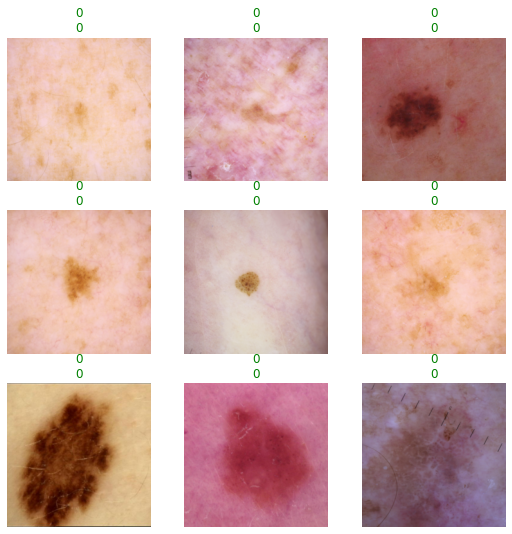

In [32]:
learn.show_results()

In [19]:
dls = dblock.dataloaders(train_df,bs=256)

learn = cnn_learner(dls, resnet18)

learn.load('fit-one-cycle-6-epochs')

In [20]:
learn.unfreeze()

In [ ]:
learn.lr_find()